# 10.2 카트폴 게임 마스터하기

In [16]:
# 필수 모듈을 임포트

import gym   # 카트폴 등의 여러 게임 환경을 제공하는 패키지
import random # 에이전트가 무작위로 행동할 확률을 구하기 위해 사용하는 파이썬의 기본 패키지
import math  # 에이전트가 무작위로 행동할 확률을 구하기 위해 사용하는 파이썬의 기본 패키지
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque   # deque는 큐 자료구조의 일종(양쪽 끝에서 삽입과 삭제가 가능한 자료구조)
import matplotlib.pyplot as plt

10.2.1 하이퍼파라미터

In [17]:
EPISODES = 50     # 총 플레이할 게임 수(에피소드 반복 횟수)
EPS_START = 0.9   # 학습 시작 시 에이전트가 무작위로 행동할 확률(50%이면 절반의 확률로 무작위로 행동하고 절반은 학습된 방향으로 행동함)
EPS_END = 0.05    # 학습 막바지에 에이전트가 무작위로 행동할 확률
EPS_DECAY = 200   # 학습 진행 시 에이전트가 무작위로 행동할 확률을 감소시키는 값(start에서 시작하는 엡실론 값을 end까지 점진적으로 감소시킴)
GAMMA = 0.8       # 에이전트가 현재 보상을 미래 보상보다 얼마나 가치 있게 여기는지에 대한 값(할인계수)
LR = 0.001        # 학습률
BATCH_SIZE = 64   # 배치 사이즈

10.2.2 DQN 에이전트 + 10.2.3 이전 경험 기억하기 + 10.2.4 행동하기 + 10.2.5 경험으로부터 배우기

In [18]:
class DQNAgent:
    def __init__(self):
        # 에이전트 신경망은 카트 위치, 카트 속도, 막대기 각도, 막대기 속도까지 4개의 정보를 입력받아 왼,오로 갈때의 가치를 출력함
        self.model = nn.Sequential(nn.Linear(4,256),nn.ReLU(), nn.Linear(256,2))  
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0  # 학습을 반복할 때마다 증가하는 변수
        self.memory = deque(maxlen=10000)   # maxlen을 지정해주면 큐가 가득 찼을 때 가장 오래된 요소부터 없어짐
    
    # 이전 경험 기억하기 -> 여기에 경험(4차원)들이 큐 상태로 들어가서 저장되는 듯
    # self.memory배열에 덧붙일 memorize 함수 
    # memorize함수는 self.memory배열에 현재 상태, 현재 상태에서 한 행동, 행동에 대한 보상, 행동으로 새로 생성된 상태를 한 세트로 저장함
    def memorize(self, state, action, reward, next_state):
        self.memory.append((state, action, torch.FloatTensor([reward]),torch.FloatTensor([next_state]))) # 왜 floattensor해주는지?
        
    # 행동하기
    def act(self,state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.*self.steps_done / EPS_DECAY)
        self.steps_done +=1
        # 엡실론 그리디(탐욕) 알고리즘
        # 무작위 숫자를 골라 엡실론 값보다 높으면 신경망이 학습하여 이렇게 행동하는게 옳다고 생각하는 쪽으로 행동
        # 엡실론 값보다 작으면 무작위로 행동함
        if random.random() > eps_threshold :
            return self.model(state).data.max(1)[1].view(1,1)   # 왜 제일 큰 값의 위치 정보를 반환?
        else :
            return torch.LongTensor([[random.randrange(2)]])  # 0,1중에 아무 값을 선택하는 거?
        
    # 경험으로 부터 배우기
    # 이전 경험들을 모아놨으면 반복적으로 학습해야함 -> 경험 리플레이
    # learn 함수가 경험 리플레이를 하며 학습하는 역할을 수행, 만들어둔 에이전트 신경망을 기억(self.memory)에 쌓인 경험을 토대로 학습시킴
    def learn(self):
        # self.memory에 저장된 경험의 수가 아직 배치 크기보다 크지 않으면 return으로 학습을 거름
        if len(self.memory) < BATCH_SIZE :
            return
        # self.memory에 저장된 경험의 수가 충분히 쌓이면 큐에서 무작위로 배치 크기 만큼의 경험들을 가져옴
        # 경험들을 무작위로 가져오면 각 경험 샘플의 상관성을 줄일 수 있음
        batch = random.sample(self.memory, BATCH_SIZE)
        # zip(*batch)는 한 세트로 모여진 states, actions, rewards, next_states를 4개의 배열로 정리해줌
        states, actions, rewards, next_states = zip(*batch)
        
        # 4개 모두 리스트의 리스트 형태이므로 torch.cat이용해서 하나의 텐서로 만듦
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)
        
        # 학습을 위한 경험 샘플들이 준비됐으니 이제 에이전트의 신경망을 학습할 차례
        # gather함수로 에이전트가 현 상태(states)에서 했던 행동의 가치를 current_q에 담는 것 
        # gather함수는 첫 번째 인수로 받은 차원(1)에서 두 번째 인수로 받은 텐서(actions)가 가리키는 값들을 추출해냄
        current_q = self.model(states).gather(1,actions)  # 현재 상태에서 에이전트가 생각하는 행동의 가치를 추출
     
        # DQN 알고리즘 학습은 할인된 미래가치로 누적된 보상을 극대화 하는 방향으로 이루어짐
        max_next_q = self.model(next_states).detach().max(1)[0]  # 다음상태에서 에이전트가 생각하는 행동의 최대가치
        # 현재 상태에서 에이전트가 행동해 받았던 보상에 에이전트가 내다보는 행동들의 미래가치가 더해서 할인된 미래가치가 expected_q에 담김
        expected_q = rewards + (GAMMA * max_next_q)
        
        # 학습은 현재 에이전트가 생각하는 행동의 가치가 할인된 미래가치를 따라가도록 진행됨
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()  
        self.optimizer.step()
        

10.2.6 학습 시작하기

In [19]:
# gym으로 게임환경을 생성하기 위해서는 make함수안에 원하는 게임이름을 넣어주면 됨
# env는 게임 환경이 되며 여기에 에이전트 행동을 입력하면 행동에 따른 다음 상태와 게임 종료 여부를 출력함
env = gym.make('CartPole-v0')

In [20]:
# 학습
agent = DQNAgent()   # 인스턴스화
score_history = []   # 학습 진행을 기록하기 위해 score_history 리스트에 점수를 저장

In [21]:
for e in range(1,EPISODES + 1):   # 에피소드는 앞서 50으로 설정했으니 50번의 게임을 플레이 하게 됨
    state = env.reset()          # 게임을 시작할 때마다 초기화된 상태를 불러와 카트폴 게임환경 상태를 초기화
    steps = 0      
    
    while True :   # 게임이 끝날 때까지 에이전트가 행동하는 것을 멈추지 앟을 것이므로 while true로 무한 반복문 만듦
        env.render()  # 게임 진행될 때 마다 env.render함수로 게임 화면을 띄움
        state = torch.FloatTensor([state])   # 현재 게임의 상태(state)를 텐서로 만듦
        action = agent.act(state)    # 상태를 받은 에이전트는 엡실론 그리디 알고리즘에 따라 action을 뱉음
        next_state, reward, done, _ = env.step(action.item())   # item함수로 에이전트가 한 행동의 번호를 추출하여 step함수에 입력하면 에이전트 행동에 따른 다음 상태, 보상, 종료여부를 출력

        if done : 
            reward = -1   # 만약 막대가 넘어져 게임이 끝났을 경우 -1의 보상(처벌)을 주고 이 경험을 기억하고 결과를 배우도록함
        agent.memorize(state, action, reward, next_state)
        agent.learn()   # 학습이 진행될수록 막대가 넘어지지 않아 게임이 끝나지 않는 방향으로 학습이 진행됨

        state = next_state
        steps +=1

        if done :   # 게임이 끝나면 done이 true가 되어 다음 코드가 실행됨
            print("에피소드:{0}  점수:{1}".format(e,steps))
            score_history.append(steps)
            break

에피소드:1  점수:11
에피소드:2  점수:11
에피소드:3  점수:9
에피소드:4  점수:29
에피소드:5  점수:10
에피소드:6  점수:10
에피소드:7  점수:16
에피소드:8  점수:14
에피소드:9  점수:9
에피소드:10  점수:17
에피소드:11  점수:18
에피소드:12  점수:15
에피소드:13  점수:12
에피소드:14  점수:10
에피소드:15  점수:11
에피소드:16  점수:10
에피소드:17  점수:18
에피소드:18  점수:10
에피소드:19  점수:9
에피소드:20  점수:19
에피소드:21  점수:12
에피소드:22  점수:10
에피소드:23  점수:15
에피소드:24  점수:14
에피소드:25  점수:70
에피소드:26  점수:93
에피소드:27  점수:60
에피소드:28  점수:74
에피소드:29  점수:71
에피소드:30  점수:100
에피소드:31  점수:94
에피소드:32  점수:55
에피소드:33  점수:109
에피소드:34  점수:71
에피소드:35  점수:87
에피소드:36  점수:85
에피소드:37  점수:137
에피소드:38  점수:200
에피소드:39  점수:139
에피소드:40  점수:117
에피소드:41  점수:200
에피소드:42  점수:200
에피소드:43  점수:187
에피소드:44  점수:200
에피소드:45  점수:200
에피소드:46  점수:200
에피소드:47  점수:87
에피소드:48  점수:198
에피소드:49  점수:152
에피소드:50  점수:116


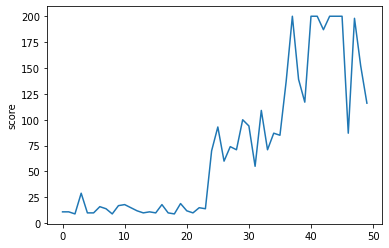

In [22]:
# 점수 기록을 그래프로 그려서 시각화
plt.plot(score_history)
plt.ylabel('score')
plt.show()